# Advanced lane finding project

In [1]:
# Importing required libraries

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline
print('Library import successful')

Library import successful


### Calibrating the camera

In [2]:
def calibrate_camera():
    
    # prepare object points
    nx = 9#TODO: enter the number of inside corners in x
    ny = 6#TODO: enter the number of inside corners in y

    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    
    objpoints = []
    imgpoints = []
    
    for fname in images:
            
        img = cv2.imread(fname)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            plt.imshow(img)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs

def test_calibration(mtx, dist):
    fname = 'camera_cal/calibration1.jpg'
    img = cv2.imread(fname)

    un_dst = cv2.undistort(img, mtx, dist, None, mtx)

    plt.imshow(un_dst)
    
def perspective_transform():
    
    fname = 'test_images/straight_lines1.jpg'
    img = cv2.imread(fname)
    
    offset_x = 300 # offset for dst points
    offset_y = 50
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])

    # For source points I'm grabbing the outer four detected corners
    src = np.float32([[580,460], [700, 460], [1040, 680], [260, 680]])
    #src = np.float32([[525,500], [760, 500], [1040, 680], [260, 680]])
    #src = np.float32([[580,410], [ 580, 890], [ 680, 1040], [ 680, 260]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[offset_x, offset_y], [img_size[0]-offset_x, offset_y], 
                                 [img_size[0]-offset_x, img_size[1]-offset_y], 
                                 [offset_x, img_size[1]-offset_y]])
    #dst = np.float32([[300,300], [1000,300], [1000,700], [300,700]])
    
    #print(dst)
    #print(dst1)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    M_inv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    
    
    return M, M_inv, img_size

print('functions defined')

functions defined


In [3]:
def abs_sobel_threshold(img, sobel_kernel=3, thresh=(20, 100)):
    # Calculate directional gradient
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    return scaled_sobelx, scaled_sobely

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255), thresh=(20, 100)):
    sobelx, sobely = abs_sobel_threshold(img, sobel_kernel, thresh)
    
    mag_sobel = ((sobelx*sobelx)+(sobely*sobely))**(1/2)
    
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return binary_output, sobelx, sobely

def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2), thresh=(20, 100)):
    
    sobelx, sobely = abs_sobel_threshold(img, sobel_kernel, thresh)
    
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output, sobelx, sobely

def combined_sobel_threshold(img, sobel_kernel=15, thresh=(200, 255), mag_thresh=(150, 255), dir_thresh=(0, np.pi/2)):
    mag_binary, sobelx, sobely = mag_threshold(img, sobel_kernel, mag_thresh, thresh)
    dir_binary, sobelx, sobely = dir_threshold(img, sobel_kernel, dir_thresh, thresh)
    combined = np.zeros_like(sobelx)
    combined[((sobelx == 1) & (sobely == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

print('functions defined')

functions defined


In [4]:
def get_s_channel_binary(img, threshold=(90, 255)):
    s_channel = img[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[((s_channel >= threshold[0]) & (s_channel <= threshold[1]))] = 1
    return s_binary

def get_h_channel_binary(img, threshold=(0, 60)):
    h_channel = img[:,:,0]
    h_binary = np.zeros_like(h_channel)
    h_binary[((h_channel >= threshold[0]) & (h_channel <= threshold[1]))] = 1
    return h_binary

def combined_color_threshold(img, s_threshold=(90, 255), h_threshold=(30, 70)):
    s_binary = get_s_channel_binary(img, s_threshold)
    h_binary = get_h_channel_binary(img, h_threshold)
    
    combined = np.zeros_like(s_binary)
    combined[(s_binary == 1) & (h_binary == 1)] = 1
    #combined[(s_binary == 1)] = 1
    return combined

In [5]:
def combined_sobel_color_threshold(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    plt.figure()
    
    combined_sobel = combined_sobel_threshold(gray)
    combined_sobel = np.uint8(combined_sobel)
    #print(combined_sobel.nonzero()[0].shape)
    #print(combined_sobel.max())
    #print(combined_sobel.dtype)
    plt.imshow(combined_sobel, cmap='gray')
    plt.figure()
    
    #combined_color = combined_color_threshold(img)
    #plt.imshow(combined_color, cmap='gray')
    #plt.figure()
    
    s_binary = get_s_channel_binary(img, threshold=(90, 255))
    h_binary = get_h_channel_binary(img, threshold=(30, 70))
    
    combined = np.zeros_like(combined_sobel)
    combined[((combined_sobel == 1) | (s_binary == 1)) | (h_binary == 1)] = 1
    return combined

In [6]:
def get_laneline_polynomials(binary_warped):
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    plt.plot(histogram)
    plt.figure()
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, left_fitx, right_fitx, ploty

In [7]:
def draw_lanelines(undist, warped, left_fitx, right_fitx, ploty, Minv, image):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

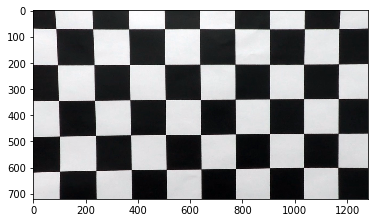

In [8]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera()

test_calibration(mtx, dist)

In [9]:
M, M_inv, img_size = perspective_transform()

In [10]:
def find_lanelines(img, mtx, dist, M, M_inv, img_size):
    un_dst = cv2.undistort(img, mtx, dist, None, mtx)
    plt.imshow(un_dst)
    plt.figure()
    
    warped = cv2.warpPerspective(un_dst, M, img_size)
    plt.imshow(warped)
    plt.figure()
    
    combined = combined_sobel_color_threshold(warped)
    plt.imshow(combined, cmap='gray')
    plt.figure()
    
    out_img, left_fitx, right_fitx, ploty = get_laneline_polynomials(combined)
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.figure()
    
    result = draw_lanelines(un_dst, combined, left_fitx, right_fitx, ploty, M_inv, img)
    plt.imshow(result)
    plt.figure()
    
    return result

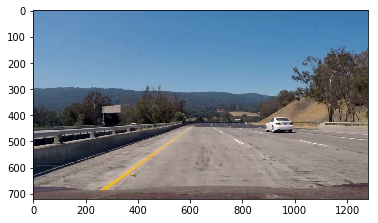

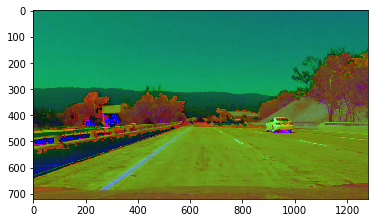

In [11]:
#fname = 'test_images/straight_lines1.jpg'
fname = 'test_images/test6.jpg'
#fname = 'custom_test_images/3.jpg'
img = cv2.imread(fname)
plt.imshow(img)
plt.figure()

hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
plt.imshow(hls)
plt.figure()

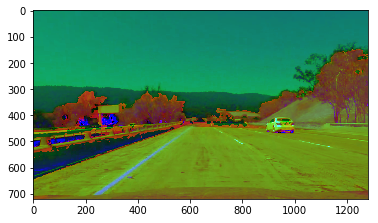

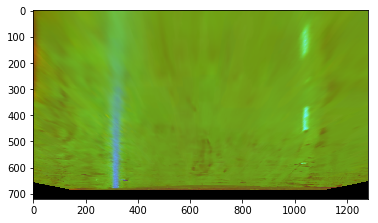

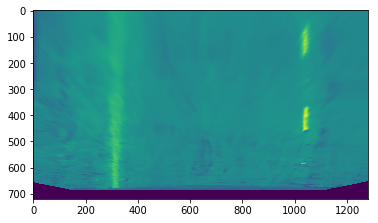

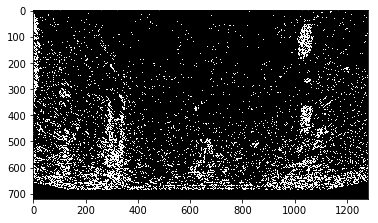

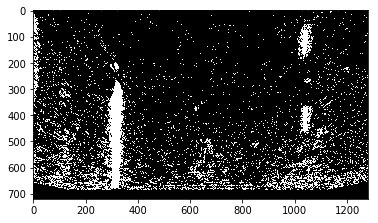

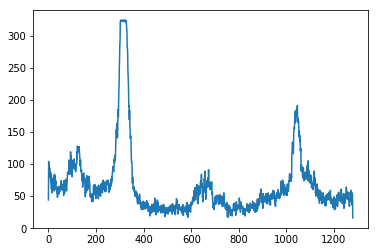

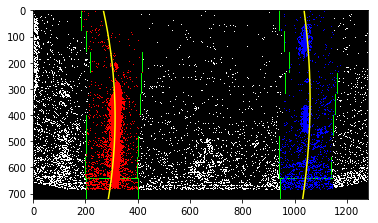

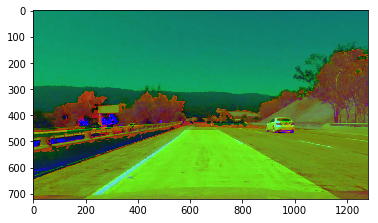

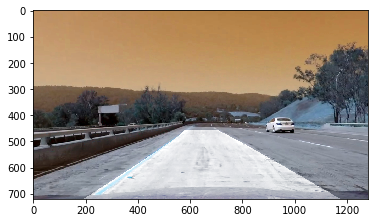

In [12]:
result = find_lanelines(hls, mtx, dist, M, M_inv, img_size)

result_rgb = cv2.cvtColor(result, cv2.COLOR_HLS2RGB)
plt.imshow(result_rgb)
plt.figure()

In [13]:
#count = 1
def process_image(img):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #global count
    #cv2.imwrite('custom_test_images/'+str(count)+'.jpg', img)
    result = find_lanelines(hls, mtx, dist, M, M_inv, img_size)

    result_rgb = cv2.cvtColor(result, cv2.COLOR_HLS2RGB)
    #plt.imshow(result_rgb)
    #plt.figure()
    #cv2.imwrite('custom_test_images/result_'+str(count)+'.jpg', result_rgb)
    #count += 1
    return result_rgb

In [ ]:
white_output = './test_videos_output/project_video_output1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("./project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/project_video_output1.mp4
[MoviePy] Writing video ./test_videos_output/project_video_output1.mp4


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [29:19<01:37,  1.02it/s]

In [ ]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))